# Data preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df_all = pd.read_csv('Data/Most+Recent+Cohorts+(All+Data+Elements).csv', low_memory=False)

In [3]:
df_BA = df_all[df_all['PREDDEG'] == 3]

In [4]:
df_BA2 = df_BA[df_BA['HIGHDEG'] == 4]

In [5]:
# carnegie classification showing if is mainly FT students

df_BA2.CCUGPROF.unique()

array([  9.,   8.,   6.,  10.,  13.,   7.,  nan,  11.,   5.,  12.,   1.,
         0.])

In [6]:
# df_BA2 = df_BA2[df_BA2['CCUGPROF'] != 1]
# df_BA2 = df_BA2[df_BA2['CCUGPROF'] != 0]
# df_BA2 = df_BA2[df_BA2['CCUGPROF'] > 10]

In [7]:
df_BA2.SAT_AVG.describe()

count    1135.000000
mean     1063.790308
std       125.261096
min       750.000000
25%       985.000000
50%      1048.000000
75%      1121.000000
max      1534.000000
Name: SAT_AVG, dtype: float64

In [8]:
df_top = df_BA2[df_BA2['SAT_AVG'].notnull()]

In [9]:
df_top = df_BA2[df_BA2['SAT_AVG'] > 1200]

This score corresponds to ~75 - 85th percentile of SAT takers.

In [10]:
df_top.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142 entries, 9 to 5987
Columns: 1728 entries, UNITID to SEPAR_DT_N
dtypes: float64(428), int64(12), object(1288)
memory usage: 1.9+ MB


In [11]:
for i in df_top.INSTNM:
    print i

Auburn University
Hendrix College
California Institute of Technology
California Polytechnic State University-San Luis Obispo
University of California-Berkeley
University of California-Los Angeles
University of California-San Diego
University of California-Santa Barbara
Chapman University
Claremont McKenna College
Loyola Marymount University
Occidental College
Pepperdine University
University of San Diego
Santa Clara University
Scripps College
University of Southern California
Colorado College
Colorado School of Mines
University of Denver
University of Connecticut
Trinity College
Wesleyan University
Yale University
American University
George Washington University
Georgetown University
Florida State University
University of Florida
University of Miami
Emory University
Georgia Institute of Technology-Main Campus
University of Georgia
University of Chicago
University of Illinois at Urbana-Champaign
Illinois Institute of Technology
Northwestern University
VanderCook College of Music
Wheaton

Now I have a reasonable subset of the universities - filtered to 4 year FT colleges, with high academic reputation (based on average SAT scores of those admitted).

Next step is to begin creating the ROI metric.

Next step after that is to go through all the features and clean them up!

In [12]:
# priv vs pub identifier field 1 - pub, 2 - priv, 3 - for profit
df_top.CONTROL.value_counts()

2    98
1    43
3     1
dtype: int64

In [13]:
# Mean earnings of students working and not enrolled 6 years after entry
# basically 2nd year salary
df_top.mn_earn_wne_p6.unique()

array(['39300', '29000', '64000', '48100', '51600', '46800', '42000',
       '38100', '43400', '59100', '36700', '60100', '48000', '51900',
       '34200', '64700', '29300', '66200', '44200', '46200', '50100',
       '38400', '76400', '45200', '56300', '86100', '37000', '45100',
       '50500', '62600', '59700', '41000', '69800', '47400', '54800',
       '65600', 'PrivacySuppressed', '37300', '52400', '23700', '68600',
       '64800', '30600', '49000', '42700', '53000', '63300', '41800',
       '36000', '68300', '59900', '62400', '48700', '40200', '33800',
       '106300', '39800', '106900', '51700', '68700', '55400', '49200',
       '55200', '45300', '70500', '71600', '45000', '60800', '44600',
       '49800', '79300', '68900', '43700', '44000', '51000', '49700',
       '62900', '47600', '45800', '34800', '44300', '42500', '47200',
       '87600', '46600', '40500', '65800', '38000', '37500', '46400',
       '32000', '27500', '38800', '56400', '70900', '92300', '42400',
       '59800',

In [14]:
# mean earnings 10 years after enrolling so ~ 6 years after graduating
df_top.mn_earn_wne_p10.value_counts()

PrivacySuppressed    3
77400                2
58300                2
65100                2
52900                2
48900                2
54000                2
63100                2
61300                2
70200                2
64300                2
59900                2
72000                2
128400               1
58100                1
78800                1
99700                1
64400                1
113400               1
67300                1
85600                1
66400                1
54200                1
64000                1
82300                1
70000                1
52700                1
107300               1
65600                1
55400                1
                    ..
65400                1
44500                1
55200                1
81300                1
83200                1
47400                1
68200                1
69600                1
123400               1
84700                1
62400                1
85800                1
66700      

Need to get rid of the privacy suppressed ones.

In [15]:
df_top = df_top[df_top['mn_earn_wne_p10'] != 'PrivacySuppressed']
df_top = df_top[df_top['mn_earn_wne_p6'] != 'PrivacySuppressed']

In [16]:
df_top = df_top[df_top['CCUGPROF'].notnull()]

# Calculating y

In [17]:
# CONTROL, NPT4_PRIV, NPT4_PUB, mn_earn_wne_p6, mn_earn_wne_p10

def NPV(Control, Edu_Price_Pvt, Edu_Price_Pub, mean_earnings_6yr, mean_earnings_10yr):
    salary_table = pd.DataFrame(0, index=np.arange(1,46,1), columns=['Earnings', 'Edu_Price', 'Opp_Cost', 'NPV'])
    
    # populating Opportunity Cost column
    salary_table.Opp_Cost[1] = 25000
    for i in range(2,16,1):
        salary_table.Opp_Cost[i] = 25000 + (((i-1)/float(15)) * 10000)
    for i in range(16, 46, 1):
        salary_table.Opp_Cost[i] = 35000
    
    # populating educational cost column
    for i in range(1,5,1):
        if Control == 1:
            salary_table.Edu_Price[i] = Edu_Price_Pub
        else:
            salary_table.Edu_Price[i] = Edu_Price_Pvt
    
    # populating lifetime earnings column
    salary_table.Earnings[5] = 0.85 * float(mean_earnings_6yr)
    salary_table.Earnings[6] = float(mean_earnings_6yr)
    for i in range(7,11,1):
        salary_table.Earnings[i] = float(mean_earnings_6yr) + (float(mean_earnings_10yr) - float(mean_earnings_6yr) \
        * (0.25 * (i - 6)))
    for i in range(11, 27, 1):
        salary_table.Earnings[i] = salary_table.Earnings[(i-1)] * 1.025
    for i in range(27, 46, 1):
        salary_table.Earnings[i] = salary_table.Earnings[(i-1)]
    
    # populating NPV column
    for i in range (1, 46, 1):
        salary_table.NPV[i] = (salary_table.Earnings[i] * (1/(1.05 ** i))) + (salary_table.Edu_Price[i] * (-1.05 ** i)) \
        + (salary_table.Opp_Cost[i] * (-1/(1.05 ** i)))
    
    return np.sum(salary_table.NPV)
    

In [18]:
# function test
NPV(1, 0, 50000, 90000, 120000)

1322512

In [19]:
df_top = df_top.copy()

In [20]:
# CONTROL, NPT4_PRIV, NPT4_PUB, mn_earn_wne_p6, mn_earn_wne_p10
df_top['y'] = np.nan
for ix in range(len(df_top)):
    df_top.y.iloc[ix] = NPV(df_top.CONTROL.iloc[ix], df_top.NPT4_PRIV.iloc[ix], df_top.NPT4_PUB.iloc[ix], 
                      df_top.mn_earn_wne_p6.iloc[ix], df_top.mn_earn_wne_p10.iloc[ix])

/Users/marekduda/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [21]:
df_top.y.describe()

count        135.000000
mean      553253.348148
std       311161.796423
min        23563.000000
25%       350623.000000
50%       491434.000000
75%       721663.000000
max      1690413.000000
Name: y, dtype: float64

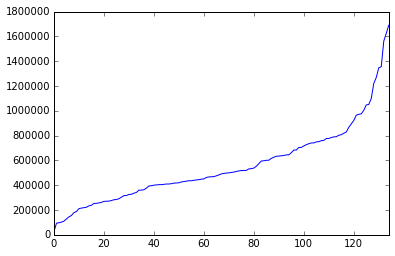

In [22]:

y_sort = df_top.sort('y')['y']
y_sort.plot(kind='line', use_index=False)

Seems like a lot of the value is in the tail!

In [23]:
import csv
with open('Columns - Sheet1 (4).csv', 'rb') as c:
    reader = csv.reader(c)
    columns = list(reader)

In [24]:
columns[0]

['PREDDEG',
 'HIGHDEG',
 'CONTROL',
 'region',
 'LOCALE',
 'locale2',
 'CCBASIC',
 'CCUGPROF',
 'CCSIZSET',
 'ADM_RATE',
 'SATVRMID',
 'SATMTMID',
 'SAT_AVG',
 'PCIP01',
 'PCIP03',
 'PCIP04',
 'PCIP05',
 'PCIP09',
 'PCIP10',
 'PCIP11',
 'PCIP12',
 'PCIP13',
 'PCIP14',
 'PCIP15',
 'PCIP16',
 'PCIP19',
 'PCIP22',
 'PCIP23',
 'PCIP24',
 'PCIP25',
 'PCIP26',
 'PCIP27',
 'PCIP29',
 'PCIP30',
 'PCIP31',
 'PCIP38',
 'PCIP39',
 'PCIP40',
 'PCIP41',
 'PCIP42',
 'PCIP43',
 'PCIP44',
 'PCIP45',
 'PCIP46',
 'PCIP47',
 'PCIP48',
 'PCIP49',
 'PCIP50',
 'PCIP51',
 'PCIP52',
 'PCIP54',
 'UGDS_WHITE',
 'UGDS_BLACK',
 'UGDS_HISP',
 'UGDS_ASIAN',
 'INEXPFTE',
 'AVGFACSAL',
 'PFTFAC',
 'PCTPELL',
 'PCTFLOAN',
 'loan_ever',
 'pell_ever',
 'age_entry',
 'agege24',
 'female',
 'married',
 'dependent',
 'veteran',
 'first_gen',
 'faminc',
 'md_faminc',
 'lnfaminc']

In [25]:
del columns[0][5]

In [26]:
X = df_top[columns[0]]

In [27]:
X.describe().T['count'].describe()

count     59
mean     135
std        0
min      135
25%      135
50%      135
75%      135
max      135
Name: count, dtype: float64

In [28]:
X.dtypes

PREDDEG         int64
HIGHDEG         int64
CONTROL         int64
region          int64
LOCALE        float64
CCBASIC       float64
CCUGPROF      float64
CCSIZSET      float64
ADM_RATE      float64
SATVRMID      float64
SATMTMID      float64
SAT_AVG       float64
PCIP01        float64
PCIP03        float64
PCIP04        float64
PCIP05        float64
PCIP09        float64
PCIP10        float64
PCIP11        float64
PCIP12        float64
PCIP13        float64
PCIP14        float64
PCIP15        float64
PCIP16        float64
PCIP19        float64
PCIP22        float64
PCIP23        float64
PCIP24        float64
PCIP25        float64
PCIP26        float64
               ...   
PCIP45        float64
PCIP46        float64
PCIP47        float64
PCIP48        float64
PCIP49        float64
PCIP50        float64
PCIP51        float64
PCIP52        float64
PCIP54        float64
UGDS_WHITE    float64
UGDS_BLACK    float64
UGDS_HISP     float64
UGDS_ASIAN    float64
INEXPFTE      float64
AVGFACSAL 

In [29]:
g = X.columns.to_series().groupby(X.dtypes).groups

In [30]:
g

{dtype('int64'): ['PREDDEG', 'HIGHDEG', 'CONTROL', 'region'],
 dtype('float64'): ['LOCALE',
  'CCBASIC',
  'CCUGPROF',
  'CCSIZSET',
  'ADM_RATE',
  'SATVRMID',
  'SATMTMID',
  'SAT_AVG',
  'PCIP01',
  'PCIP03',
  'PCIP04',
  'PCIP05',
  'PCIP09',
  'PCIP10',
  'PCIP11',
  'PCIP12',
  'PCIP13',
  'PCIP14',
  'PCIP15',
  'PCIP16',
  'PCIP19',
  'PCIP22',
  'PCIP23',
  'PCIP24',
  'PCIP25',
  'PCIP26',
  'PCIP27',
  'PCIP29',
  'PCIP30',
  'PCIP31',
  'PCIP38',
  'PCIP39',
  'PCIP40',
  'PCIP41',
  'PCIP42',
  'PCIP43',
  'PCIP44',
  'PCIP45',
  'PCIP46',
  'PCIP47',
  'PCIP48',
  'PCIP49',
  'PCIP50',
  'PCIP51',
  'PCIP52',
  'PCIP54',
  'UGDS_WHITE',
  'UGDS_BLACK',
  'UGDS_HISP',
  'UGDS_ASIAN',
  'INEXPFTE',
  'AVGFACSAL',
  'PFTFAC',
  'PCTPELL',
  'PCTFLOAN'],
 dtype('O'): ['loan_ever',
  'pell_ever',
  'age_entry',
  'agege24',
  'female',
  'married',
  'dependent',
  'veteran',
  'first_gen',
  'faminc',
  'md_faminc',
  'lnfaminc']}

In [31]:
objects = ['loan_ever',
  'pell_ever',
  'age_entry',
  'agege24',
  'female',
  'married',
  'dependent',
  'veteran',
  'first_gen',
  'faminc',
  'md_faminc',
  'lnfaminc']

In [32]:
X[objects] = X[objects].astype('float')

/Users/marekduda/anaconda/lib/python2.7/site-packages/pandas/core/frame.py:2148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [33]:
X.describe().T['count'].describe()

count     71
mean     135
std        0
min      135
25%      135
50%      135
75%      135
max      135
Name: count, dtype: float64

In [34]:
y = df_top.y

I have my X and y, time to make dummies from categorical features.

In [35]:
with open('Columns - Sheet2 (1).csv', 'rb') as c:
    reader = csv.reader(c)
    categoricals = list(reader)[0]

In [36]:
categoricals

['PREDDEG',
 'HIGHDEG',
 'CONTROL',
 'region',
 'LOCALE',
 'CCBASIC',
 'CCUGPROF',
 'CCSIZSET']

In [37]:
X_categoricals = pd.get_dummies(X[categoricals], columns=categoricals)

In [38]:
X = X.drop(categoricals, 1)

In [39]:
X_full = pd.concat([X, X_categoricals], axis=1)

# Decision tree

First I will make a decision tree, and try to get an idea of what features are important. I will then look into normalising the X matrix and doing a linear regression.

In [40]:
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.metrics import roc_auc_score

In [41]:
X1, X2, y1, y2 = train_test_split(X_full, y)

In [42]:
dtmodel = DecisionTreeRegressor(max_depth=4)
dtmodel.fit(X_full, y)

DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, random_state=None,
           splitter='best')

In [43]:
dtmodel.score(X2, y2)

0.76746327598680253

In [44]:
# pd.DataFrame(data=(dtmodel.feature_importances_, X_full.columns))

data = np.array([X_full.columns, dtmodel.feature_importances_])

Feature_Importances = pd.DataFrame(data).T

In [45]:
Feature_Importances.sort(1, ascending=False).head(10)

,0,1
3,SAT_AVG,0.6053545
2,SATMTMID,0.110257
38,PCIP50,0.09711257
18,PCIP23,0.05206899
50,PCTFLOAN,0.03177506
60,faminc,0.02339212
55,female,0.01990665
25,PCIP31,0.01712664
45,UGDS_ASIAN,0.01111215
12,PCIP13,0.009977157


In [46]:
import pydot
from sklearn.externals.six import StringIO  
dot_data = StringIO()
tree.export_graphviz(dtmodel, out_file=dot_data, feature_names=X_full.columns, max_depth=3) 
graph = pydot.graph_from_dot_data(dot_data.getvalue()) 
graph.write_pdf("dtmodel.pdf") 

True

# Linear model

In [47]:
from sklearn.linear_model import LinearRegression

In [48]:
lrmodel = LinearRegression(normalize=True)

In [54]:
lrmodel.fit(X_normed, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [55]:
lrmodel.score(X_normed, y)

0.96766288310016846

In [56]:
data = np.array([X_full.columns, lrmodel.coef_])

Coefficients = pd.DataFrame(data).T

In [57]:
Coefficients.sort(1, ascending=False).head(10)

,0,1
13,PCIP14,1.146999e+07
40,PCIP52,9096572
33,PCIP45,6596136
38,PCIP50,3602889
39,PCIP51,3596130
8,PCIP09,3438149
21,PCIP26,2737090
12,PCIP13,2619526
15,PCIP16,2434351
10,PCIP11,2239390


In [58]:
Coefficients.sort(1, ascending=False).tail(10)

,0,1
94,CCUGPROF_8.0,-53807.27
59,first_gen,-67382.24
51,loan_ever,-73927.58
46,INEXPFTE,-77302.82
56,married,-79364.1
1,SATVRMID,-86538.85
55,female,-86827.72
61,md_faminc,-106738.1
53,age_entry,-120120.8
57,dependent,-147397.1


In [50]:
from sklearn.preprocessing import StandardScaler

In [51]:
scaler = StandardScaler()

In [52]:
X_normed = scaler.fit_transform(X_full)

In [53]:
X_normed

array([[ 1.84711847, -1.45722665, -1.43700475, ...,  3.74165739,
        -0.45316348, -0.5802014 ],
       [ 1.73813161, -0.74334423, -1.43700475, ..., -0.26726124,
        -0.45316348, -0.5802014 ],
       [-1.50086491,  2.41813505,  2.46674147, ..., -0.26726124,
        -0.45316348, -0.5802014 ],
       ..., 
       [ 1.15980563, -1.04929384,  0.51486836, ..., -0.26726124,
         2.20670914, -0.5802014 ],
       [-1.726259  ,  1.80623583,  1.64490016, ..., -0.26726124,
        -0.45316348,  1.72353945],
       [ 0.81197525, -1.35524345, -0.82062377, ..., -0.26726124,
         2.20670914, -0.5802014 ]])

In [59]:
import statsmodels.api as sm

In [60]:
X_full = sm.add_constant(X_full)

In [61]:
model = sm.OLS(y, X_full)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     11.41
Date:                Tue, 29 Sep 2015   Prob (F-statistic):           6.74e-13
Time:                        11:48:46   Log-Likelihood:                -1666.9
No. Observations:                 135   AIC:                             3530.
Df Residuals:                      37   BIC:                             3815.
Df Model:                          97                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
ADM_RATE        -1.2e+05    1.8e+05     -0.666

# Stepwise feature selection

Since I am having trouble figuring out which features matter, I will try a stepwise approach.

In [62]:
X_full.columns.values

array(['ADM_RATE', 'SATVRMID', 'SATMTMID', 'SAT_AVG', 'PCIP01', 'PCIP03',
       'PCIP04', 'PCIP05', 'PCIP09', 'PCIP10', 'PCIP11', 'PCIP12',
       'PCIP13', 'PCIP14', 'PCIP15', 'PCIP16', 'PCIP19', 'PCIP22',
       'PCIP23', 'PCIP24', 'PCIP25', 'PCIP26', 'PCIP27', 'PCIP29',
       'PCIP30', 'PCIP31', 'PCIP38', 'PCIP39', 'PCIP40', 'PCIP41',
       'PCIP42', 'PCIP43', 'PCIP44', 'PCIP45', 'PCIP46', 'PCIP47',
       'PCIP48', 'PCIP49', 'PCIP50', 'PCIP51', 'PCIP52', 'PCIP54',
       'UGDS_WHITE', 'UGDS_BLACK', 'UGDS_HISP', 'UGDS_ASIAN', 'INEXPFTE',
       'AVGFACSAL', 'PFTFAC', 'PCTPELL', 'PCTFLOAN', 'loan_ever',
       'pell_ever', 'age_entry', 'agege24', 'female', 'married',
       'dependent', 'veteran', 'first_gen', 'faminc', 'md_faminc',
       'lnfaminc', 'PREDDEG_3', 'HIGHDEG_4', 'CONTROL_1', 'CONTROL_2',
       'region_1', 'region_2', 'region_3', 'region_4', 'region_5',
       'region_6', 'region_7', 'region_8', 'LOCALE_11.0', 'LOCALE_12.0',
       'LOCALE_13.0', 'LOCALE_21.0', 'LOC

In [79]:
# steps = [4:43, 43:47, 49:53, 53:55, 60:63, 65:67, 67:75, 75:85, 85:92, 92:98, 98:]
non_grouped_features = [0,1,2,3,47,48,55,56,57,58,59]

In [80]:
model = sm.OLS(y, X_full.iloc[:, 98:])
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.236
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     4.872
Date:                Tue, 29 Sep 2015   Prob (F-statistic):           2.98e-05
Time:                        11:49:33   Log-Likelihood:                -1880.4
No. Observations:                 135   AIC:                             3779.
Df Residuals:                     126   BIC:                             3805.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
CCSIZSET_6.0   5.951e+05    2.8e+05      2.122

In [81]:
model = sm.OLS(y, X_full.iloc[:, 93:98])
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     1.662
Date:                Tue, 29 Sep 2015   Prob (F-statistic):              0.163
Time:                        11:49:33   Log-Likelihood:                -1895.2
No. Observations:                 135   AIC:                             3800.
Df Residuals:                     130   BIC:                             3815.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
CCUGPROF_7.0   4.828e+05   3.08e+05      1.567

In [82]:
model = sm.OLS(y, X_full.iloc[:, 85:93])
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                     4.772
Date:                Tue, 29 Sep 2015   Prob (F-statistic):           8.63e-05
Time:                        11:49:33   Log-Likelihood:                -1882.8
No. Observations:                 135   AIC:                             3782.
Df Residuals:                     127   BIC:                             3805.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
CCBASIC_15.0   7.03e+05   3.64e+04     19.306   

In [83]:
model = sm.OLS(y, X_full.iloc[:, 75:85])
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                 -0.018
Method:                 Least Squares   F-statistic:                    0.7426
Date:                Tue, 29 Sep 2015   Prob (F-statistic):              0.669
Time:                        11:49:33   Log-Likelihood:                -1895.0
No. Observations:                 135   AIC:                             3810.
Df Residuals:                     125   BIC:                             3839.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
LOCALE_11.0  5.316e+05   4.53e+04     11.735      

In [84]:
model = sm.OLS(y, X_full.iloc[:, 67:75])
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     2.246
Date:                Tue, 29 Sep 2015   Prob (F-statistic):             0.0346
Time:                        11:49:33   Log-Likelihood:                -1890.7
No. Observations:                 135   AIC:                             3797.
Df Residuals:                     127   BIC:                             3821.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
region_1    7.416e+05   7.11e+04     10.436      0.0

In [85]:
model = sm.OLS(y, X_full.iloc[:, 65:67])
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     8.801
Date:                Tue, 29 Sep 2015   Prob (F-statistic):            0.00357
Time:                        11:49:33   Log-Likelihood:                -1894.2
No. Observations:                 135   AIC:                             3792.
Df Residuals:                     133   BIC:                             3798.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
CONTROL_1   4.403e+05   4.61e+04      9.545      0.0

In [86]:
model = sm.OLS(y, X_full.iloc[:, 60:63])
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                     167.7
Date:                Tue, 29 Sep 2015   Prob (F-statistic):           7.57e-45
Time:                        11:49:33   Log-Likelihood:                -1889.1
No. Observations:                 135   AIC:                             3784.
Df Residuals:                     132   BIC:                             3793.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
faminc        15.9389      3.939      4.046      0.0

In [87]:
model = sm.OLS(y, X_full.iloc[:, 53:55])
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                     260.0
Date:                Tue, 29 Sep 2015   Prob (F-statistic):           1.10e-46
Time:                        11:49:33   Log-Likelihood:                -1887.8
No. Observations:                 135   AIC:                             3780.
Df Residuals:                     133   BIC:                             3785.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age_entry   2.045e+04   1942.163     10.530      0.0

In [88]:
model = sm.OLS(y, X_full.iloc[:, 49:53])
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     167.7
Date:                Tue, 29 Sep 2015   Prob (F-statistic):           1.63e-50
Time:                        11:49:33   Log-Likelihood:                -1872.9
No. Observations:                 135   AIC:                             3754.
Df Residuals:                     131   BIC:                             3765.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
PCTPELL     1.935e+06   5.97e+05      3.244      0.0

In [89]:
model = sm.OLS(y, X_full.iloc[:, 42:46])
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     134.2
Date:                Tue, 29 Sep 2015   Prob (F-statistic):           2.46e-45
Time:                        11:49:33   Log-Likelihood:                -1885.2
No. Observations:                 135   AIC:                             3778.
Df Residuals:                     131   BIC:                             3790.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
UGDS_WHITE  3.553e+05   7.87e+04      4.515      0.0

In [90]:
model = sm.OLS(y, X_full.iloc[:, 4:42])
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     29.15
Date:                Tue, 29 Sep 2015   Prob (F-statistic):           1.32e-38
Time:                        11:49:33   Log-Likelihood:                -1829.7
No. Observations:                 135   AIC:                             3731.
Df Residuals:                      99   BIC:                             3836.
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
PCIP01      8.954e+05   1.28e+06      0.701      0.4

In [91]:
for i in non_grouped_features:
    model = sm.OLS(y, X_full.iloc[:, i])
    results = model.fit()
    print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.395
Model:                            OLS   Adj. R-squared:                  0.390
Method:                 Least Squares   F-statistic:                     87.47
Date:                Tue, 29 Sep 2015   Prob (F-statistic):           2.59e-16
Time:                        11:49:33   Log-Likelihood:                -1961.3
No. Observations:                 135   AIC:                             3925.
Df Residuals:                     134   BIC:                             3927.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
ADM_RATE    8.299e+05   8.87e+04      9.353      0.0

In [92]:
steps[0]

NameError: name 'steps' is not defined

In [ ]:
for i in steps:
    model = sm.OLS(y, X_full.iloc[:, float(i)])
    results = model.fit()
    print(results.summary())

In [93]:
model = sm.OLS(y, X_full.iloc[:, 1])
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     535.7
Date:                Tue, 29 Sep 2015   Prob (F-statistic):           1.17e-48
Time:                        11:49:48   Log-Likelihood:                -1886.6
No. Observations:                 135   AIC:                             3775.
Df Residuals:                     134   BIC:                             3778.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
SATVRMID     881.6890     38.093     23.145      0.0

# Random Forest

Final model to fit and extract feature importances for.

In [94]:
from sklearn.ensemble import RandomForestRegressor

In [95]:
rfmodel = RandomForestRegressor(n_estimators=50, max_depth=4)
rfmodel.fit(X_full, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [96]:
rfmodel.score(X2, y2)

0.86108777381266333

In [97]:
data = np.array([X_full.columns, rfmodel.feature_importances_])

Feature_Importances_rf = pd.DataFrame(data).T

Feature_Importances_rf.sort(1, ascending=False).head(10)

,0,1
3,SAT_AVG,0.4529714
2,SATMTMID,0.1272548
0,ADM_RATE,0.1231546
47,AVGFACSAL,0.0641713
38,PCIP50,0.04304071
18,PCIP23,0.01962487
59,first_gen,0.01215031
13,PCIP14,0.01038452
45,UGDS_ASIAN,0.008753984
30,PCIP42,0.008082249


Random Forest offers a more stable set of feature importances. The one thing that is clear is that SAT is a very strong predictor of career earnings, which makes sense - but is also likely to obfuscate the effect of attendance at an institution. SAT is good proxy for general competence, and therefore stripping this effect out would seem valuable. I will create a second y column, where I will take away the y predicted by an SAT_AVG only model from the true y.

# Controlling for SAT

In [118]:
smOLS_model = sm.OLS(y, X_full.SAT_AVG)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     537.5
Date:                Tue, 29 Sep 2015   Prob (F-statistic):           9.75e-49
Time:                        11:55:04   Log-Likelihood:                -1886.4
No. Observations:                 135   AIC:                             3775.
Df Residuals:                     134   BIC:                             3778.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
SAT_AVG      432.1935     18.642     23.184      0.0

In [120]:
smOLS_model.predict(X_full.SAT_AVG.reshape(1, 135))

array([[ 1476225.,  1539405.,  1863810., ...,  1540620.,  1781190.,
         1471365.],
       [ 1539405.,  1605289.,  1943578., ...,  1606556.,  1857422.,
         1534337.],
       [ 1863810.,  1943578.,  2353156., ...,  1945112.,  2248844.,
         1857674.],
       ..., 
       [ 1540620.,  1606556.,  1945112., ...,  1607824.,  1858888.,
         1535548.],
       [ 1781190.,  1857422.,  2248844., ...,  1858888.,  2149156.,
         1775326.],
       [ 1471365.,  1534337.,  1857674., ...,  1535548.,  1775326.,
         1466521.]])

In [101]:
lrmodel.fit(X_full.SAT_AVG.reshape(135, 1), y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

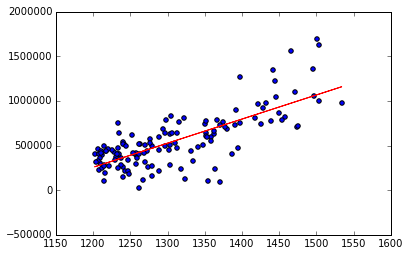

In [102]:
y_SAT = lrmodel.predict(X_full.SAT_AVG.reshape(135, 1))
plt.plot(X_full.SAT_AVG, y_SAT, 'r')
plt.scatter(X_full.SAT_AVG, y)

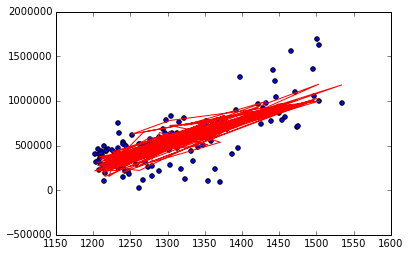

In [103]:
lrmodel.fit(X_full[['SAT_AVG', 'SATMTMID', 'SATVRMID', 'faminc']], y)
y_SAT_plus = lrmodel.predict(X_full[['SAT_AVG', 'SATMTMID', 'SATVRMID', 'faminc']])
plt.plot(X_full.SAT_AVG, y_SAT_plus, c='r')
plt.scatter(X_full.SAT_AVG, y)

ValueError: shapes (135,1) and (4,) not aligned: 1 (dim 1) != 4 (dim 0)

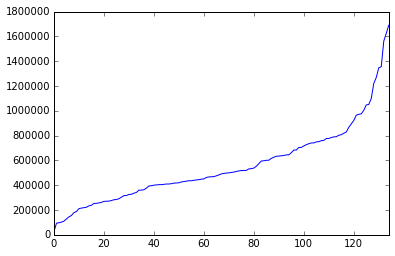

In [105]:
# plot actual y
y_sort = df_top.sort('y')['y']
y_sort.plot(kind='line', use_index=False)

# plot SAT predicted y
y_SAT = lrmodel.predict(X_full.SAT_AVG.reshape(135, 1))
y_SAT = pd.Series(y_SAT)
y_SAT_sort = y_SAT.sort()
y_SAT.plot(kind='line', use_index=False)

It would seem that SAT alone underpredicts schools at top end and over predicts at bottom end - but this is flawed, since the sort will scramble data points. Need to try and plot the actual scatter of SAT to y and plot the line of predictions.

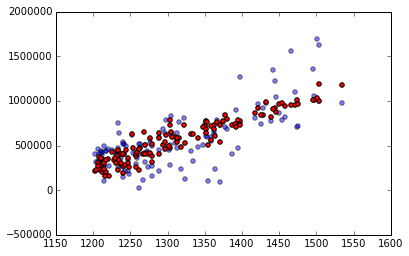

In [108]:
x = df_top.SAT_AVG
y = df_top.y

plt.scatter(x, y, alpha=0.5)
plt.scatter(X_full.SAT_AVG, y_SAT_plus, c='r')

In [109]:
df_top.sort('y', ascending=False)[['INSTNM', 'SAT_AVG', 'y']]

,INSTNM,SAT_AVG,y
1852,Harvard University,1501,1690413
1875,Massachusetts Institute of Technology,1503,1623643
4561,Stanford University,1466,1561305
2515,Princeton University,1495,1355538
3604,University of Pennsylvania,1442,1346653
801,Georgetown University,1398,1268602
2921,Duke University,1444,1220736
2631,Columbia University in the City of New York,1471,1098861
782,Yale University,1497,1050900
2420,Dartmouth College,1446,1047569


In [122]:
df_top['earnings_per_SAT'] = df_top.y / df_top.SAT_AVG

In [123]:
df_top.sort('y', ascending=False)[['INSTNM', 'SAT_AVG', 'y', 'earnings_per_SAT']]

,INSTNM,SAT_AVG,y,earnings_per_SAT
1852,Harvard University,1501,1690413,1126.191206
1875,Massachusetts Institute of Technology,1503,1623643,1080.268130
4561,Stanford University,1466,1561305,1065.010232
2515,Princeton University,1495,1355538,906.714381
3604,University of Pennsylvania,1442,1346653,933.878641
801,Georgetown University,1398,1268602,907.440629
2921,Duke University,1444,1220736,845.385042
2631,Columbia University in the City of New York,1471,1098861,747.016315
782,Yale University,1497,1050900,702.004008
2420,Dartmouth College,1446,1047569,724.459889


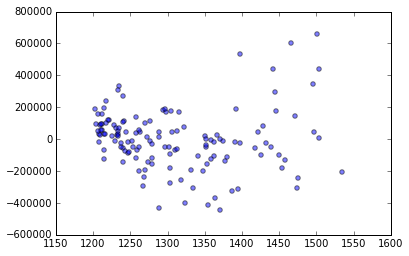

In [110]:
x = df_top.SAT_AVG
y = df_top.y - y_SAT_plus

plt.scatter(x, y, alpha=0.5)


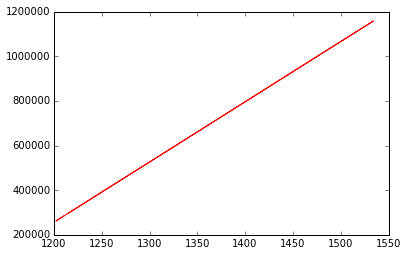

In [111]:
plt.plot(df_top.SAT_AVG, y_SAT, c='r')

In [112]:
np.shape(X_full.SAT_AVG)

(135,)

In [113]:
np.shape(y)

(135,)

In [114]:
X_full.SAT_AVG.reshape(1, 135)

array([[ 1215.,  1267.,  1534.,  1242.,  1350.,  1289.,  1276.,  1212.,
         1208.,  1397.,  1202.,  1303.,  1235.,  1228.,  1294.,  1364.,
         1380.,  1323.,  1298.,  1231.,  1233.,  1240.,  1387.,  1497.,
         1258.,  1297.,  1398.,  1212.,  1272.,  1332.,  1363.,  1352.,
         1247.,  1504.,  1303.,  1252.,  1458.,  1318.,  1212.,  1262.,
         1450.,  1214.,  1240.,  1208.,  1341.,  1418.,  1209.,  1310.,
         1221.,  1234.,  1375.,  1279.,  1347.,  1240.,  1501.,  1209.,
         1503.,  1394.,  1428.,  1439.,  1352.,  1206.,  1270.,  1263.,
         1243.,  1237.,  1474.,  1214.,  1446.,  1495.,  1210.,  1305.,
         1235.,  1370.,  1471.,  1358.,  1422.,  1225.,  1258.,  1352.,
         1303.,  1366.,  1232.,  1353.,  1247.,  1297.,  1253.,  1274.,
         1217.,  1444.,  1313.,  1229.,  1377.,  1240.,  1354.,  1289.,
         1279.,  1279.,  1371.,  1334.,  1306.,  1432.,  1322.,  1442.,
         1258.,  1316.,  1425.,  1259.,  1237.,  1288.,  1248., 

# Refitting model with y_SAT_plus

In [115]:
X_modified = X_full.drop(axis=1, labels=['SAT_AVG', 'SATMTMID', 'SATVRMID', 'faminc', 'ADM_RATE'])

In [116]:
rfmodel.fit(X_modified, (y - y_SAT_plus))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [117]:
data = np.array([X_modified.columns, rfmodel.feature_importances_])

Feature_Importances_rf = pd.DataFrame(data).T

Feature_Importances_rf.sort(1, ascending=False).head(10)

,0,1
42,INEXPFTE,0.3169676
43,AVGFACSAL,0.07355099
2,PCIP04,0.0550455
34,PCIP50,0.04806931
36,PCIP52,0.04396238
55,first_gen,0.0370075
24,PCIP40,0.02976091
41,UGDS_ASIAN,0.02639894
44,PFTFAC,0.01927824
49,age_entry,0.0191508


Now refit it to earnings per SAT as y, see what comes out

In [124]:
X_modified = X_full.drop(axis=1, labels=['SAT_AVG', 'SATMTMID', 'SATVRMID', 'faminc', 'ADM_RATE'])

rfmodel.fit(X_modified, (df_top.earnings_per_SAT))

data = np.array([X_modified.columns, rfmodel.feature_importances_])

Feature_Importances_rf = pd.DataFrame(data).T

Feature_Importances_rf.sort(1, ascending=False).head(10)

,0,1
43,AVGFACSAL,0.4772777
42,INEXPFTE,0.05656929
9,PCIP14,0.05343117
46,PCTFLOAN,0.04428829
41,UGDS_ASIAN,0.03982097
48,pell_ever,0.03847665
34,PCIP50,0.0363551
14,PCIP23,0.03384775
45,PCTPELL,0.02537491
51,female,0.01803198


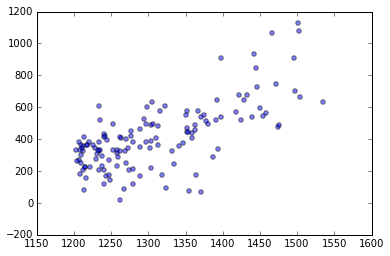

In [150]:
x = df_top.SAT_AVG
y = df_top.earnings_per_SAT

plt.scatter(x, y, alpha=0.5)
#plt.scatter(X_full.SAT_AVG, y_SAT_plus, c='r')

Going to fit a linear model to predict earnings per SAT.

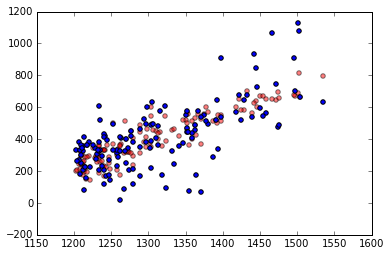

In [151]:
lrmodel.fit(X_full[['SAT_AVG', 'SATMTMID', 'SATVRMID', 'faminc']], df_top.earnings_per_SAT)
y_earn_SAT = lrmodel.predict(X_full[['SAT_AVG', 'SATMTMID', 'SATVRMID', 'faminc']])
plt.scatter(X_full.SAT_AVG, y_earn_SAT, c='r', alpha=.5)
plt.scatter(X_full.SAT_AVG, df_top.earnings_per_SAT)

do the same with the random forest

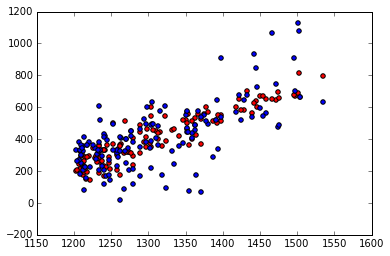

In [130]:
rfmodel.fit(X_full[['SAT_AVG', 'SATMTMID', 'SATVRMID', 'faminc']], df_top.earnings_per_SAT)
y_earn_SAT = lrmodel.predict(X_full[['SAT_AVG', 'SATMTMID', 'SATVRMID', 'faminc']])
plt.scatter(X_full.SAT_AVG, y_earn_SAT, c='r')
plt.scatter(X_full.SAT_AVG, df_top.earnings_per_SAT)

predictions are similar - and we saw above that most important features are expenditure per student and faculty salary.

In [131]:
df_top.earnings_per_SAT.mean()

413.00095054050496

In [133]:
df_top['diff_true_pred_eps'] = df_top.earnings_per_SAT - y_earn_SAT

In [134]:
df_top.sort('diff_true_pred_eps', ascending=False)[['INSTNM', 'SAT_AVG', 'y', 'earnings_per_SAT', 'diff_true_pred_eps']]

,INSTNM,SAT_AVG,y,earnings_per_SAT,diff_true_pred_eps
1852,Harvard University,1501,1690413,1126.191206,438.557976
4561,Stanford University,1466,1561305,1065.010232,412.116939
801,Georgetown University,1398,1268602,907.440629,395.414379
3604,University of Pennsylvania,1442,1346653,933.878641,308.848439
1875,Massachusetts Institute of Technology,1503,1623643,1080.268130,263.431704
529,Pepperdine University,1235,639260,517.619433,261.855446
1812,Bentley University,1234,751111,608.679903,243.139278
2515,Princeton University,1495,1355538,906.714381,226.710400
2921,Duke University,1444,1220736,845.385042,205.573083
777,Trinity College,1240,538173,434.010484,205.166083


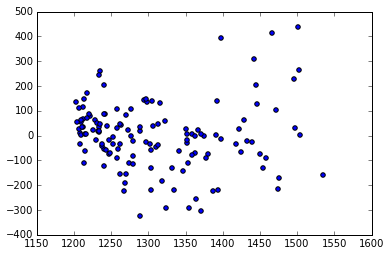

In [152]:
plt.scatter(X_full.SAT_AVG, df_top.diff_true_pred_eps)


In [135]:
df_top['y_SAT_pred_binary'] = df_top.diff_true_pred_eps > 0

In [137]:
from sklearn.ensemble import RandomForestClassifier

In [141]:
rfcmodel = RandomForestClassifier()

X_modified = X_full.drop(axis=1, labels=['SAT_AVG', 'SATMTMID', 'SATVRMID', 'faminc', 'ADM_RATE'])

rfcmodel.fit(X_modified, (df_top.y_SAT_pred_binary))

data = np.array([X_modified.columns, rfcmodel.feature_importances_])

Feature_Importances_rf = pd.DataFrame(data).T

Feature_Importances_rf.sort(1, ascending=False).head(10)

,0,1
18,PCIP27,0.07194434
34,PCIP50,0.04847105
49,age_entry,0.04812487
37,PCIP54,0.04225682
51,female,0.0418055
9,PCIP14,0.04002701
29,PCIP45,0.03726391
46,PCTFLOAN,0.03593988
41,UGDS_ASIAN,0.03359135
40,UGDS_HISP,0.03206295


Very interesting - so when a classifier tries to predict whether the earnings per SAT are above or below what SAT & faminc would predict, having a high proprtion of weak subjects seems to be very important. Faculty salary is out of the top 10 completely. I should run this through a decision tree and see the print out. 

Could also try to rank the subjects based on hardness vs softness and use it as a non categorical feature.

In [139]:
from sklearn.tree import DecisionTreeClassifier

In [147]:
dtcmodel = DecisionTreeClassifier(max_depth=4)

X_modified = X_full.drop(axis=1, labels=['SAT_AVG', 'SATMTMID', 'SATVRMID', 'faminc', 'ADM_RATE'])

dtcmodel.fit(X_modified, (df_top.y_SAT_pred_binary))

data = np.array([X_modified.columns, dtcmodel.feature_importances_])

Feature_Importances_rf = pd.DataFrame(data).T

Feature_Importances_rf.sort(1, ascending=False).head(10)

,0,1
22,PCIP38,0.2567737
34,PCIP50,0.1489588
17,PCIP26,0.1483097
24,PCIP40,0.1196068
5,PCIP10,0.08610445
18,PCIP27,0.07931822
52,married,0.06679429
12,PCIP19,0.05238768
53,dependent,0.04174643
10,PCIP15,0


In [148]:
import pydot
from sklearn.externals.six import StringIO  
dot_data = StringIO()
tree.export_graphviz(dtcmodel, out_file=dot_data, feature_names=X_modified.columns, max_depth=5) 
graph = pydot.graph_from_dot_data(dot_data.getvalue()) 
graph.write_pdf("dtcmodel1.pdf") 

True

The decision tree would seem to confirm that the most important features for predicting whether a school will under over perform the prediction based on SAT/faminc is the proportion of people graduating from different subjects.

So I could create a feature from the subjects - and see how this performs.

Why has the academic salary feature disppeared now?

Academic salary etc came up most in regression models, so will do a regression model on the diff.

In [153]:
rfmodel = RandomForestRegressor()

rfmodel.fit(X_modified, (df_top.diff_true_pred_eps))

data = np.array([X_modified.columns, rfmodel.feature_importances_])

Feature_Importances_rf = pd.DataFrame(data).T

Feature_Importances_rf.sort(1, ascending=False).head(10)

,0,1
34,PCIP50,0.07442823
43,AVGFACSAL,0.07043119
46,PCTFLOAN,0.0699722
3,PCIP05,0.04689133
17,PCIP26,0.0447187
22,PCIP38,0.04360625
29,PCIP45,0.0405289
44,PFTFAC,0.03673723
24,PCIP40,0.03653621
12,PCIP19,0.03279236


So the facsalary comes back in the regressor - it is probably necessary to explain the big deviation at the top of the model - I wonder whether it is also useful to predict the below average ones - will cut out top 10 schools and re run this model.

In [156]:
df_wo_elite = df_top[df_top.earnings_per_SAT < 700]

First I will create a feature out of subject percentages, dividing them into Arts/Humanities, Social Science, STEM and Vocational.

In [159]:
with open('Columns - Subject Mapping.csv', 'rb') as c:
    reader = csv.reader(c)
    subject_map = list(reader)

In [162]:
subject_map

[['code', 'Focus', 'Class'],
 ['PCIP01',
  'Agriculture, Agriculture Operations, and Related Sciences',
  'Vocational'],
 ['PCIP03', 'Natural Resources and Conservation', 'Vocational'],
 ['PCIP04', 'Architecture and Related Services', 'Arts/Humanities'],
 ['PCIP05',
  'Area, Ethnic, Cultural, Gender, and Group Studies',
  'Arts/Humanities'],
 ['PCIP09',
  'Communication, Journalism, and Related Programs',
  'Arts/Humanities'],
 ['PCIP10',
  'Communications Technologies/Technicians and Support Services',
  'Vocational'],
 ['PCIP11', 'Computer and Information Sciences and Support Services', 'STEM'],
 ['PCIP12', 'Personal and Culinary Services', 'Vocational'],
 ['PCIP13', 'Education', 'Social Science'],
 ['PCIP14', 'Engineering', 'STEM'],
 ['PCIP15', 'Engineering Technologies and Engineering-Related Fields', 'STEM'],
 ['PCIP16',
  'Foreign Languages, Literatures, and Linguistics',
  'Arts/Humanities'],
 ['PCIP19', 'Family and Consumer Sciences/Human Sciences', 'Social Science'],
 ['PCIP22

In [164]:
df_subject_map = pd.DataFrame(subject_map[1:], columns=subject_map[0])

In [187]:
df_top['Arts_Humanities'], df_top['Social_Science'], df_top['STEM'], df_top['Vocational'] = 0, 0, 0, 0

In [171]:
df_subject_map

,code,Focus,Class
0,PCIP01,"Agriculture, Agriculture Operations, and Relat...",Vocational
1,PCIP03,Natural Resources and Conservation,Vocational
2,PCIP04,Architecture and Related Services,Arts/Humanities
3,PCIP05,"Area, Ethnic, Cultural, Gender, and Group Studies",Arts/Humanities
4,PCIP09,"Communication, Journalism, and Related Programs",Arts/Humanities
5,PCIP10,Communications Technologies/Technicians and Su...,Vocational
6,PCIP11,Computer and Information Sciences and Support ...,STEM
7,PCIP12,Personal and Culinary Services,Vocational
8,PCIP13,Education,Social Science
9,PCIP14,Engineering,STEM


In [180]:
df_subject_map.groupby('Class')['code'].unique()

Class
Arts/Humanities    [PCIP04, PCIP05, PCIP09, PCIP16, PCIP23, PCIP2...
STEM               [PCIP11, PCIP14, PCIP15, PCIP26, PCIP27, PCIP2...
Social Science     [PCIP13, PCIP19, PCIP22, PCIP42, PCIP44, PCIP4...
Vocational         [PCIP01, PCIP03, PCIP10, PCIP12, PCIP25, PCIP3...
Name: code, dtype: object

In [189]:
for code in df_subject_map.groupby('Class')['code'].unique()[0]:
    df_top['Arts_Humanities'] += df_top[code]
    
for code in df_subject_map.groupby('Class')['code'].unique()[1]:
    df_top['STEM'] += df_top[code]

for code in df_subject_map.groupby('Class')['code'].unique()[2]:
    df_top['Social_Science'] += df_top[code]

for code in df_subject_map.groupby('Class')['code'].unique()[3]:
    df_top['Vocational'] += df_top[code]


In [191]:
df_top.Arts_Humanities
df_top.STEM

9       0.3013
171     0.3089
244     0.9844
246     0.4734
266     0.3378
269     0.3202
271     0.4309
273     0.2118
300     0.0838
309     0.1004
441     0.1266
510     0.2076
529     0.0465
557     0.1183
578     0.2476
583     0.2311
610     0.2234
662     0.2415
667     0.9827
681     0.1191
728     0.3174
777     0.1629
779     0.1936
782     0.2462
794     0.0555
800     0.2896
801     0.1840
854     0.1701
858     0.3002
909     0.3555
         ...  
3671    0.3946
3691    0.3431
3722    0.3783
3733    0.2661
3871    0.2651
3877    0.1903
3901    0.2842
3925    0.3226
3949    0.1869
4035    0.4958
4054    0.2035
4079    0.3024
4080    0.3234
4084    0.2373
4096    0.2326
4116    0.3173
4154    0.1814
4172    0.2084
4228    0.1425
4257    0.3574
4260    0.2986
4268    0.1874
4297    0.2773
4322    0.1872
4343    0.3694
4424    0.3616
4430    0.8156
4464    0.3404
4561    0.4162
4562    0.4279
Name: STEM, dtype: float64

In [193]:
df_subject_map.code.unique()

array(['PCIP01', 'PCIP03', 'PCIP04', 'PCIP05', 'PCIP09', 'PCIP10',
       'PCIP11', 'PCIP12', 'PCIP13', 'PCIP14', 'PCIP15', 'PCIP16',
       'PCIP19', 'PCIP22', 'PCIP23', 'PCIP24', 'PCIP25', 'PCIP26',
       'PCIP27', 'PCIP29', 'PCIP30', 'PCIP31', 'PCIP38', 'PCIP39',
       'PCIP40', 'PCIP41', 'PCIP42', 'PCIP43', 'PCIP44', 'PCIP45',
       'PCIP46', 'PCIP47', 'PCIP48', 'PCIP49', 'PCIP50', 'PCIP51',
       'PCIP52', 'PCIP54'], dtype=object)

In [196]:
X_wo_subj = X_full.drop(axis=1, labels=df_subject_map.code.unique())

In [197]:
X_full_w_subj_groups = pd.concat([X_wo_subj, df_top['Arts_Humanities'], df_top['Social_Science'], df_top['STEM'], df_top['Vocational']], axis=1)

In [201]:
X_full_w_subj_groups.columns

Index([u'ADM_RATE', u'SATVRMID', u'SATMTMID', u'SAT_AVG', u'UGDS_WHITE',
       u'UGDS_BLACK', u'UGDS_HISP', u'UGDS_ASIAN', u'INEXPFTE', u'AVGFACSAL',
       u'PFTFAC', u'PCTPELL', u'PCTFLOAN', u'loan_ever', u'pell_ever',
       u'age_entry', u'agege24', u'female', u'married', u'dependent',
       u'veteran', u'first_gen', u'faminc', u'md_faminc', u'lnfaminc',
       u'PREDDEG_3', u'HIGHDEG_4', u'CONTROL_1', u'CONTROL_2', u'region_1',
       u'region_2', u'region_3', u'region_4', u'region_5', u'region_6',
       u'region_7', u'region_8', u'LOCALE_11.0', u'LOCALE_12.0',
       u'LOCALE_13.0', u'LOCALE_21.0', u'LOCALE_22.0', u'LOCALE_23.0',
       u'LOCALE_31.0', u'LOCALE_32.0', u'LOCALE_33.0', u'LOCALE_42.0',
       u'CCBASIC_15.0', u'CCBASIC_16.0', u'CCBASIC_17.0', u'CCBASIC_18.0',
       u'CCBASIC_19.0', u'CCBASIC_20.0', u'CCBASIC_21.0', u'CCBASIC_22.0',
       u'CCUGPROF_7.0', u'CCUGPROF_8.0', u'CCUGPROF_9.0', u'CCUGPROF_12.0',
       u'CCUGPROF_13.0', u'CCSIZSET_6.0', u'CCSIZSET_8.0

# Refitting models using new subject areas features

In [212]:
dtmodel2 = DecisionTreeRegressor(max_depth=3)

X_modified2 = X_full_w_subj_groups.drop(axis=1, labels=['SAT_AVG', 'SATMTMID', 'SATVRMID', 
                                                        'faminc', 'md_faminc', 'ADM_RATE'])

dtmodel2.fit(X_modified2, y)

data = np.array([X_modified2.columns, dtmodel2.feature_importances_])

Feature_Importances = pd.DataFrame(data).T

Feature_Importances.sort(1, ascending=False).head(10)

,0,1
5,AVGFACSAL,0.7083049
7,PCTPELL,0.1134112
63,Arts_Humanities,0.1074179
17,first_gen,0.04433117
10,pell_ever,0.02653479
6,PFTFAC,0
8,PCTFLOAN,0
9,loan_ever,0
11,age_entry,0
12,agege24,0


In [213]:
import pydot
from sklearn.externals.six import StringIO  
dot_data = StringIO()
tree.export_graphviz(dtmodel2, out_file=dot_data, feature_names=X_modified2.columns, max_depth=3) 
graph = pydot.graph_from_dot_data(dot_data.getvalue()) 
graph.write_pdf("dtcmodel2.pdf") 

True

In [219]:
dtmodel2 = DecisionTreeRegressor(max_depth=4)

X_modified2 = X_full_w_subj_groups.drop(axis=1, labels=['SAT_AVG', 'SATMTMID', 'SATVRMID', 
                                                        'faminc', 'md_faminc', 'ADM_RATE'])

dtmodel2.fit(X_modified2, df_top.diff_true_pred_eps)

data = np.array([X_modified2.columns, dtmodel2.feature_importances_])

Feature_Importances = pd.DataFrame(data).T

Feature_Importances.sort(1, ascending=False).head(10)

,0,1
5,AVGFACSAL,0.3959498
64,Social_Science,0.3349519
47,CCBASIC_21.0,0.1380578
21,CONTROL_1,0.07054451
6,PFTFAC,0.04037815
1,UGDS_BLACK,0.02011789
9,loan_ever,0
10,pell_ever,0
11,age_entry,0
12,agege24,0


In [220]:
import pydot
from sklearn.externals.six import StringIO  
dot_data = StringIO()
tree.export_graphviz(dtmodel2, out_file=dot_data, feature_names=X_modified2.columns, max_depth=4) 
graph = pydot.graph_from_dot_data(dot_data.getvalue()) 
graph.write_pdf("dtcmodel3.pdf") 

True

In [223]:
dtmodel2 = DecisionTreeClassifier(max_depth=4)

X_modified2 = X_full_w_subj_groups.drop(axis=1, labels=['SAT_AVG', 'SATMTMID', 'SATVRMID', 
                                                        'faminc', 'md_faminc', 'ADM_RATE'])

dtmodel2.fit(X_modified2, df_top.y_SAT_pred_binary)

data = np.array([X_modified2.columns, dtmodel2.feature_importances_])

Feature_Importances = pd.DataFrame(data).T

Feature_Importances.sort(1, ascending=False).head(10)

,0,1
63,Arts_Humanities,0.1751415
5,AVGFACSAL,0.1645146
4,INEXPFTE,0.1594668
64,Social_Science,0.1380103
10,pell_ever,0.1296213
2,UGDS_HISP,0.07537217
33,LOCALE_13.0,0.05838203
49,CCUGPROF_7.0,0.05527292
13,female,0.04421834
14,married,0


In [224]:
import pydot
from sklearn.externals.six import StringIO  
dot_data = StringIO()
tree.export_graphviz(dtmodel2, out_file=dot_data, feature_names=X_modified2.columns, max_depth=4) 
graph = pydot.graph_from_dot_data(dot_data.getvalue()) 
graph.write_pdf("dtcmodel4.pdf") 

True

In [225]:
rfmodel2 = RandomForestClassifier(max_depth=4)

X_modified2 = X_full_w_subj_groups.drop(axis=1, labels=['SAT_AVG', 'SATMTMID', 'SATVRMID', 
                                                        'faminc', 'md_faminc', 'ADM_RATE'])

rfmodel2.fit(X_modified2, df_top.y_SAT_pred_binary)

data = np.array([X_modified2.columns, rfmodel2.feature_importances_])

Feature_Importances = pd.DataFrame(data).T

Feature_Importances.sort(1, ascending=False).head(10)

,0,1
0,UGDS_WHITE,0.1164194
7,PCTPELL,0.1011458
64,Social_Science,0.09212088
10,pell_ever,0.08834596
18,lnfaminc,0.05202225
5,AVGFACSAL,0.0498304
8,PCTFLOAN,0.04967351
2,UGDS_HISP,0.04738359
13,female,0.04036744
3,UGDS_ASIAN,0.03935892


In [226]:
rfrmodel2 = RandomForestRegressor(max_depth=4)

X_modified2 = X_full_w_subj_groups.drop(axis=1, labels=['SAT_AVG', 'SATMTMID', 'SATVRMID', 
                                                        'faminc', 'md_faminc', 'ADM_RATE'])

rfrmodel2.fit(X_modified2, df_top.diff_true_pred_eps)

data = np.array([X_modified2.columns, rfrmodel2.feature_importances_])

Feature_Importances = pd.DataFrame(data).T

Feature_Importances.sort(1, ascending=False).head(10)

,0,1
5,AVGFACSAL,0.1651318
8,PCTFLOAN,0.1308522
64,Social_Science,0.0920351
47,CCBASIC_21.0,0.08624762
4,INEXPFTE,0.07082589
65,STEM,0.05274133
12,agege24,0.04790409
63,Arts_Humanities,0.04159634
44,CCBASIC_18.0,0.03861981
18,lnfaminc,0.03693572


should also fit some linears and logits.

In [227]:
linear_model = LinearRegression(normalize=True)

X_modified2 = X_full_w_subj_groups.drop(axis=1, labels=['SAT_AVG', 'SATMTMID', 'SATVRMID', 
                                                        'faminc', 'md_faminc', 'ADM_RATE'])

linear_model.fit(X_modified2, df_top.diff_true_pred_eps)

data = np.array([X_modified2.columns, linear_model.coef_])

Feature_Importances = pd.DataFrame(data).T

Feature_Importances.sort(1, ascending=False).head(10)

,0,1
64,Social_Science,58090.88
65,STEM,57870.66
63,Arts_Humanities,57745.42
66,Vocational,57134.88
12,agege24,1705.549
16,veteran,1043.458
7,PCTPELL,990.6091
1,UGDS_BLACK,565.3567
18,lnfaminc,547.7057
10,pell_ever,505.4432
